### Set if you work in pycharm or in native jupyter environment (recommended): used for plotting

In [1]:
IN_PYCHARM : bool = False

### Preliminary imports and settings

In [2]:
# Imports
from math import isclose
from copy import deepcopy
from IPython.display import clear_output
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

import contracts
import geometry as geo

import duckietown_world as dw
from duckietown_world.svg_drawing.ipython_utils import ipython_draw_html, ipython_draw_svg
from duckietown_world.world_duckietown.tile import get_lane_poses
from duckietown_world.world_duckietown.tile_utils import get_tile_at_point
from duckietown_world.rules.rule import evaluate_rules

# Some settings
contracts.disable_all()
dw.logger.setLevel(50)
d = "out/"

INFO:geometry:version: 2.0.5
INFO:commons:version: 6.1.5
INFO:typing:version: 6.1.8
DEBUG:duckietown_world:duckietown-world version 6.2.7 path /home/chrigi/Master-Thesis-Code/driving-games/venv/lib/python3.8/site-packages


### Define some useful functions

In [3]:
def draw_object(pl_ob: dw.PlacedObject, outdir=None, area=None, in_pycharm: bool = IN_PYCHARM):
    if in_pycharm:
        ipython_draw_html(po=pl_ob, outdir=outdir, area=area)
        clear_output(wait=True)
        ipython_draw_svg(m=pl_ob, outdir=outdir)
    else:
        ipython_draw_html(po=pl_ob, outdir=outdir, area=area)

def draw_graph(G0, pos=None):
    pos = pos or nx.spring_layout(G0)
    plt.figure(figsize=(12, 12))
    nx.draw(G0,pos,labels={node:node for node in G0.nodes()})
    def edge_label(a, b):
        datas = G0.get_edge_data(a, b)
        s = '%d edge%s' % (len(datas), 's' if len(datas)>=2 else '')
        for k, v in datas.items():
            if v:
                if 'label' in v:
                    s += '\n %s' % v['label']
                else:
                    s += '\n %s' %v
        return s
    edge_labels = dict([ ((a,b), edge_label(a,b)) for a,b in G0.edges()])
    nx.draw_networkx_edge_labels(G0,pos,edge_labels=edge_labels,font_color='red')
    plt.axis('off')
    plt.show()

### Better Visualisation of output

In [4]:
%%html
<style>
pre {line-height: 90%}
</style>

### Import and draw the map

In [5]:
duckie_map = dw.load_map('4way')

dirname = d + "4way"
draw_object(duckie_map, outdir=dirname)

INFO:duckietown_world: data: /home/chrigi/Master-Thesis-Code/driving-games/venv/lib/python3.8/site-packages/duckietown_world/data
INFO:duckietown_world: area: RectangularArea(pmin=[0. 0.],pmax=[2.87117992 2.87117992])
DEBUG:commons.fs:already up to date out/4way/drawing.html
INFO:duckietown_world:Written SVG
 fn_svg: out/4way/drawing.svg


### Get skeleton graph (contains the lane segments and the graph interconnecting them)

In [6]:
skeleton_graph = dw.get_skeleton_graph(duckie_map)

### Get the map of the joined lane segments and draw it (check box "map lane segments" to see it)

In [7]:
joined_lane_segments = skeleton_graph.root2

dirname = d + "4wayjoinedlane"
draw_object(joined_lane_segments, outdir=dirname)

INFO:duckietown_world: area: RectangularArea(pmin=[0. 0.],pmax=[2.87117995 2.87117995])
DEBUG:commons.fs:already up to date out/4wayjoinedlane/drawing.html
INFO:duckietown_world:Written SVG
 fn_svg: out/4wayjoinedlane/drawing.svg


### Get the graph of the topology

In [8]:
topology_graph = skeleton_graph.G

### Draw the graph

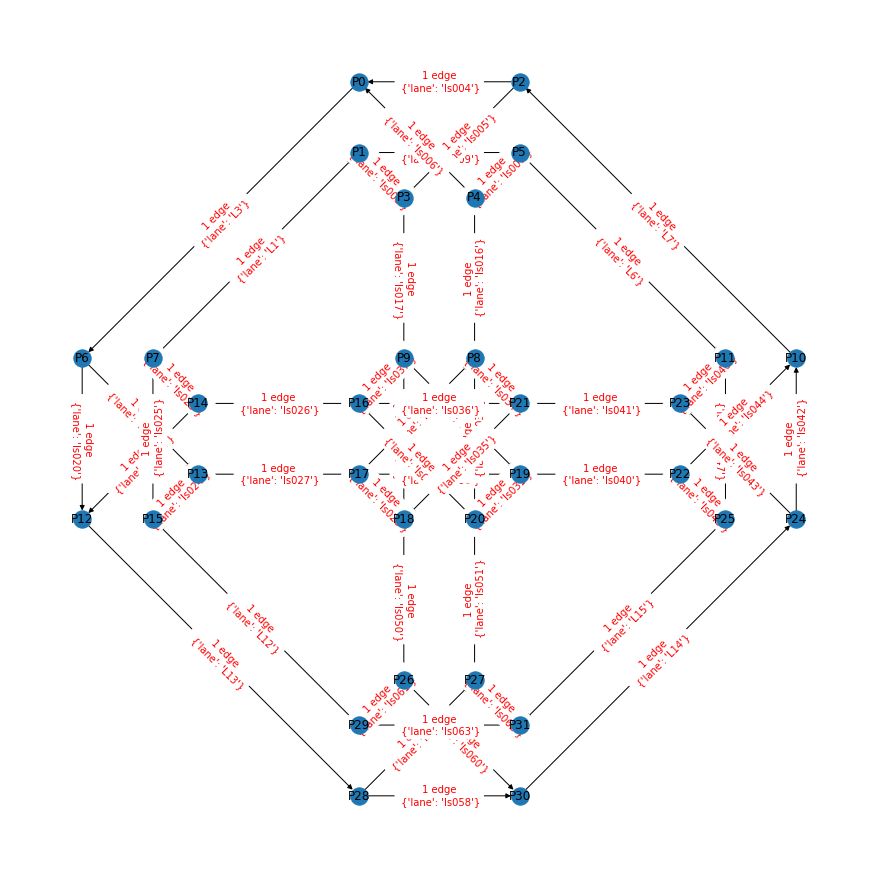

In [9]:
pos = {}
for n in topology_graph:
    q = topology_graph.nodes[n]['point'].as_SE2()
    t, _ = geo.translation_angle_from_SE2(q)
    pos[n] = t
draw_graph(topology_graph, pos=pos)

### Extract the shortest path from a start node to an end node as list

In [10]:
start = "P27"
end = "P9"

path = nx.shortest_path(topology_graph, start, end)

def get_lanes(path, graph):
    edges = zip(path[:-1], path[1:])
    lanes =[]
    for a, b in edges:
        lane = graph.get_edge_data(a, b)[0]['lane']
        lanes.append(lane)
    return lanes

lanes = get_lanes(path, topology_graph)
print(lanes)

['ls051', 'ls031', 'ls040', 'ls044', 'L7', 'ls005', 'ls017']


### Extract the lane segments and draw them

In [11]:
lane_segments_to_follow = [joined_lane_segments.children[lane_name] for lane_name in lanes]

lane_points = []
po = dw.PlacedObject()
for lane_name, lane in zip(lanes, lane_segments_to_follow):
    po.set_object(lane_name, lane, ground_truth=dw.SE2Transform.identity())

dirname = d + "extractedlane"
draw_object(po, outdir = dirname)

INFO:duckietown_world: area: RectangularArea(pmin=[0. 0.],pmax=[2.87117995 2.87117995])
DEBUG:commons.fs:Written 0.0MB to: out/extractedlane/drawing.html
INFO:duckietown_world:Written SVG
 fn_svg: out/extractedlane/drawing.svg


### Get the width of one of the lane segments

In [12]:
width = lane_segments_to_follow[0].width

### Merge the extracted lane segments to have one unified lane

In [13]:
import itertools as it

# Make a list of all the control points, while making sure that the points that overlap are only taken once
lane_segments_to_follow_control_points = list(  
    it.chain(
        *[ls.control_points[:-1] if ls is not lane_segments_to_follow[-1]
          else ls.control_points for ls in lane_segments_to_follow]
    )
)

# Creating a unified lane segment
lane_segments_to_follow_unified = dw.LaneSegment(
    width=width, control_points=lane_segments_to_follow_control_points
)

# Draw the unified lane segment
po = dw.PlacedObject()
po.set_object("Unified Lane", lane_segments_to_follow_unified, ground_truth=dw.SE2Transform.identity())
dirname = d + "unified_lane"
draw_object(po, outdir=dirname)

INFO:duckietown_world: area: RectangularArea(pmin=[0. 0.],pmax=[2.87117995 2.87117995])
DEBUG:commons.fs:Written 0.0MB to: out/unified_lane/drawing.html
INFO:duckietown_world:Written SVG
 fn_svg: out/unified_lane/drawing.svg


### Check if the merged lane has the same total length as the sum of its parts

In [14]:
sum_lane_lengths = sum([ln.get_lane_length() for ln in lane_segments_to_follow])
sum_lane_segmenst_unified = lane_segments_to_follow_unified.get_lane_length()
msg = f"Lanes have not the same lenght: {sum_lane_lengths} is not {sum_lane_segmenst_unified}"
assert isclose(sum_lane_segmenst_unified , sum_lane_lengths, abs_tol=1e-5), msg

### Interpolate along the center line

In [15]:
npoints = len(lane_segments_to_follow_unified.control_points) # get the control points of the lane
points = 15
betas = list(np.linspace(0, npoints-1, points))  # first control point beta=0, last control point beta=nbpoints-1

transforms = []
for beta in betas:
    p = lane_segments_to_follow_unified.center_point(beta)  # get interpolated pose in SE(2)
    transform = dw.SE2Transform.from_SE2(p)  # Transform to SE2Transform 
    transforms.append(transform)

ground_truth = dw.SampledSequence[dw.SE2Transform](betas, transforms) # Setting the sequence for animation
duckie_map_lanefollow = deepcopy(duckie_map)  # copy the map  to prevent adding objects to the "original" map
duckie_map_lanefollow.set_object("Duckie", dw.DB18(), ground_truth=ground_truth) # add a duckie with the sequence
dirname = d + "lane_follow_unified"
draw_object(duckie_map_lanefollow, outdir=dirname)

INFO:duckietown_world: area: RectangularArea(pmin=[0. 0.],pmax=[2.87117992 2.87117992])
DEBUG:commons.fs:Written 0.5MB to: out/lane_follow_unified/drawing.html
INFO:duckietown_world:Written SVG
 fn_svg: out/lane_follow_unified/drawing.svg


### Define functions to interpolate along center line beta=0 start beta=1 end

In [16]:
from typing import List

def interpolate(lane: dw.LaneSegment, beta: float) -> dw.SE2Transform:
    """ Interpolate along the centerline of a lane. Start: beta=0, End beta=1 """
    n_ctr_points = len(lane.control_points) # get the control points of the lane
    dw_beta = beta * (n_ctr_points - 1) # transform the beta to the beta used by duckietown world
    p = lane.center_point(dw_beta) # get the pose
    transform = dw.SE2Transform.from_SE2(p) # transform the pose
    return transform

def interpolate_n_points(lane: dw.LaneSegment, betas: List[float]) -> List[dw.SE2Transform]:
    """ Get pose sequence as a SE2Transform along the center line of a lane, beta=0 start beta=1 end """
    msg = f"betas = {betas} have to be in ascending order to follow a lane"
    assert all(map(isclose, sorted(betas), betas)), msg  # check if values are ascending
    transforms = [interpolate(lane, beta) for beta in betas]
    return transforms


### Test the functions

In [17]:
points = 60 # number of interpolation points
betas = list(np.linspace(0,1,points))
timestamps = range(points)
transforms = interpolate_n_points(lane_segments_to_follow_unified, betas)  # get the pose sequence

# Animation
ground_truth = dw.SampledSequence[dw.SE2Transform](timestamps, transforms)
duckie_map_lanefollow = deepcopy(duckie_map)
duckie_map_lanefollow.set_object("Duckie", dw.DB18(), ground_truth=ground_truth)
dirname = d + "lane_follow_interpolated"
draw_object(duckie_map_lanefollow, outdir=dirname)


INFO:duckietown_world: area: RectangularArea(pmin=[0. 0.],pmax=[2.87117992 2.87117992])
DEBUG:commons.fs:Written 0.6MB to: out/lane_follow_interpolated/drawing.html
INFO:duckietown_world:Written SVG
 fn_svg: out/lane_follow_interpolated/drawing.svg


### Define functions to interpolate along the centerlines when the position along the lane is known

In [18]:
def interpolate_along_lane(lane: dw.LaneSegment, along_lane: float) -> dw.SE2Transform:
    """ Input: lane and 1D position along the lane. Output: Pose on the duckietown map """
    dw_beta = lane.beta_from_along_lane(along_lane=along_lane)  # get the beta in in the dw representation
    p = lane.center_point(dw_beta)  # get pose
    transform = dw.SE2Transform.from_SE2(p)
    return transform

def interpolate_along_lane_n_points(
    lane: dw.LaneSegment,
    positions_along_lane: List[float]
) -> List[dw.SE2Transform]:
    """ Input: lane and sequence of 1D positions along the lane. Output: Pose sequence on the duckietown map """
    msg = f"Positions={positions_along_lane} have to be in ascending order to follow a lane"
    assert all(map(isclose, sorted(positions_along_lane), positions_along_lane)), msg
    transforms = [interpolate_along_lane(lane, along_lane) for along_lane in positions_along_lane]
    return transforms

### Test functions

In [19]:
max_length = lane_segments_to_follow_unified.get_lane_length()  # get total length of the lane
points = 100  # number of points to interpolate
positions_along_lane = list(np.linspace(0, max_length, points))  # sequence of 1D position along the lane
timestamps = range(points) # just number of points
transforms = interpolate_along_lane_n_points(lane_segments_to_follow_unified, positions_along_lane)

# Animation
ground_truth = dw.SampledSequence[dw.SE2Transform](timestamps, transforms)
duckie_map_lanefollow = deepcopy(duckie_map)
duckie_map_lanefollow.set_object("Duckie", dw.DB18(), ground_truth=ground_truth)
dirname = d + "lane_follow_along_lane_interpolated"
draw_object(duckie_map_lanefollow, outdir=dirname)

INFO:duckietown_world: area: RectangularArea(pmin=[0. 0.],pmax=[2.87117992 2.87117992])
DEBUG:commons.fs:Written 0.8MB to: out/lane_follow_along_lane_interpolated/drawing.html
INFO:duckietown_world:Written SVG
 fn_svg: out/lane_follow_along_lane_interpolated/drawing.svg


## Collection of other useful functions

### Sample some center line points of a lane (default 5 points)

In [20]:
lane_points = lane_segments_to_follow_unified.center_line_points()  # in SE(2)
print(lane_points)

[array([[ 2.83276934e-16, -1.00000000e+00,  1.59119999e+00],
       [ 1.00000000e+00,  2.83276934e-16,  5.84999919e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]), array([[ 2.83276934e-16, -1.00000000e+00,  1.59119999e+00],
       [ 1.00000000e+00,  2.83276934e-16,  7.03828052e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]), array([[ 2.83276934e-16, -1.00000000e+00,  1.59119999e+00],
       [ 1.00000000e+00,  2.83276934e-16,  8.22656184e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]), array([[ 2.83276934e-16, -1.00000000e+00,  1.59119999e+00],
       [ 1.00000000e+00,  2.83276934e-16,  9.41484317e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]), array([[ 2.83276934e-16, -1.00000000e+00,  1.59119999e+00],
       [ 1.00000000e+00,  2.83276934e-16,  1.06031245e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]), array([[ 0.01227154, -0.9999247 ,  1.59118776],
       [ 0.9999247 ,  0.01227154,  1.1720

### Get the coordinates of the tile for a certain pose on the map

In [21]:
q = lane_points[2]  # some pose
tile_at_point = get_tile_at_point(duckie_map, q)
print(tile_at_point)

TileCoords(i=2,j=1,orientation=S)


### Get a collection of useful information for the pose in the map

In [22]:
lane_poses = list(get_lane_poses(duckie_map, q))
print(lane_poses)

[GetLanePoseResult(tile=Tile(children={'straight': PlacedObject(children={'lane1': LaneSegment(children={}, spatial_relations={}), 'lane2': LaneSegment(children={}, spatial_relations={})}, spatial_relations={'lane1': GroundTruth(() -> ('lane1',)  SE2Transform([0.0, 0.0],0.0)), 'lane2': GroundTruth(() -> ('lane2',)  SE2Transform([0.0, 0.0],180.0))})}, spatial_relations={1: GroundTruth(() -> ('straight',)  SE2Transform([0.0, 0.0],0.0))}), tile_fqn=('tilemap', 'tile-2-1'), tile_transform=TransformSequence([Scale2D(scale=0.585), TileCoords(i=2,j=1,orientation=S)]), tile_relative_pose=Matrix2D(m=[[-1.7094017e+00 -1.7022208e-16  9.3750097e-02]
 [ 1.7022208e-16 -1.7094017e+00  2.2000001e-01]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]), lane_segment=LaneSegment(children={}, spatial_relations={}), lane_segment_fqn=('tilemap', 'tile-2-1', 'straight', 'lane2'), lane_pose=LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=-1.7453869655126297e-08,lateral_l

### Get the evaluation of a simulated sequence

In [25]:
timestamps_as_floats = list(map(float, timestamps))  # timestamps have to be floats for it to work
evaluated_rules = evaluate_rules(
    poses_sequence=ground_truth,
    interval=dw.SampledSequence[dw.Timestamp](timestamps_as_floats, timestamps_as_floats),
    world=duckie_map,
    ego_name="Duckie"
)
for key, item in evaluated_rules.items():
    print(f"{key} : {item}\n")

deviation-heading : RuleEvaluationResult(<duckietown_world.rules.in_drivable_lane.DeviationHeading object at 0x7fbf5f8e32b0>, {(): EvaluatedMetric(Deviation from lane direction, 1.3068866785594142e-05)})

in-drivable-lane : RuleEvaluationResult(<duckietown_world.rules.in_drivable_lane.InDrivableLane object at 0x7fbf5fe09310>, {(): EvaluatedMetric(Drivable areas, 0.0)})

deviation-center-line : RuleEvaluationResult(<duckietown_world.rules.in_drivable_lane.DeviationFromCenterLine object at 0x7fbfc01a4f70>, {(): EvaluatedMetric(Deviation from center line, 5.973571260118465e-06)})

driving-distance : RuleEvaluationResult(<duckietown_world.rules.in_drivable_lane.DrivenLength object at 0x7fbfc01a4eb0>, {('driven_any',): EvaluatedMetric(Distance, 5.1488560411039845), ('driven_lanedir',): EvaluatedMetric(Lane distance, 5.141970443702339)})

driving-distance-consecutive : RuleEvaluationResult(<duckietown_world.rules.in_drivable_lane.DrivenLengthConsecutive object at 0x7fbf5ad71fa0>, {('driven_l

### Get a LanePose for a certain pose with very detailed information

Information about the "position in the lane"
Am I inside the lane? If not why not?

In [24]:
lane_pose = lane_segments_to_follow_unified.lane_pose_from_SE2(q)
print(lane_pose)
print("\n")
print(lane_pose.inside)
print("\n")
print(lane_pose.correct_direction)

LanePose(inside=True,lateral_inside=True,outside_left=False,outside_right=False,lateral=0.0,lateral_left=0.10997999596595764,lateral_right=-0.10997999596595764,along_inside=True,along_before=False,along_after=False,along_lane=0.2376268703930273,relative_heading=0.0,distance_from_left=0.10997999596595764,distance_from_right=0.10997999596595764,distance_from_center=0.0,center_point=SE2Transform([1.5911999940872192, 0.8226267893307104],90.0),correct_direction=True)


True


True
